In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

sns.set_style('darkgrid')
%matplotlib inline

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/natural-language-processing-with-disaster-tweets/sample_submission.csv
/kaggle/input/natural-language-processing-with-disaster-tweets/train.csv
/kaggle/input/natural-language-processing-with-disaster-tweets/test.csv


**Part I: Exploratory Data Analysis**

In [2]:
#Load in Data
df = pd.read_csv("/kaggle/input/natural-language-processing-with-disaster-tweets/train.csv")

In [3]:
#Get Summary of Data
print('Number of Rows: {}, Number of Columns:{}\n\n'.format(*df.shape))
print(df.info())

Number of Rows: 7613, Number of Columns:5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None


In [4]:
df.head(5)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
#drop duplicates
df.drop_duplicates(subset=['text'],
                       keep='first',
                       inplace=True)


In [6]:
#see new data spread
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7503 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7503 non-null   int64 
 1   keyword   7447 non-null   object
 2   location  5021 non-null   object
 3   text      7503 non-null   object
 4   target    7503 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 351.7+ KB


In [7]:
df['text_length'] = df['text'].apply(len)
df['text_hashtags'] = df['text'].str.count('#')
target_count = df['target'].value_counts()

In [8]:
#text length range
print(df['text_length'].min())
print(df['text_length'].max())
print(df['text_length'].median())
print(df['text_length'].mean())

7
157
107.0
100.88058110089298


Text(0.5, 1.0, 'Lengths of Tweets')

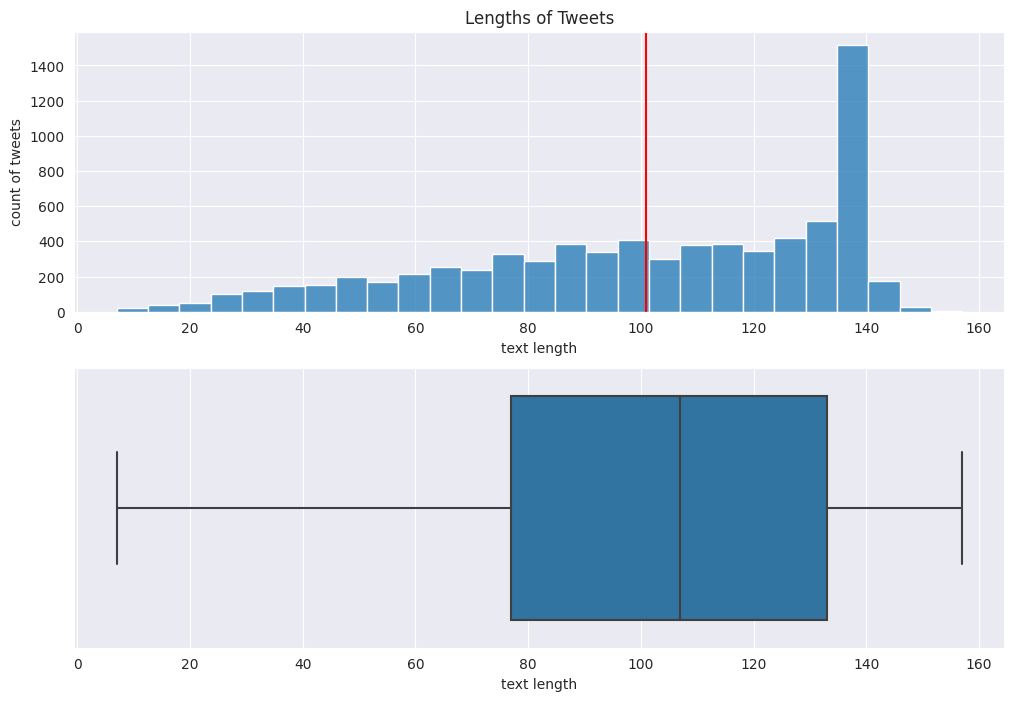

In [9]:
#plot text lengths
fig,ax = plt.subplots(2,1,figsize=(12,8))
sns.histplot(x=df['text_length'], ax=ax[0]);
sns.boxplot(x=df['text_length'], ax=ax[1]);
ax[0].set_xlabel('text length')
ax[0].set_ylabel('count of tweets')
ax[0].axvline(df['text_length'].mean(),color='r')
ax[1].set_xlabel('text length')
ax[0].set_title('Lengths of Tweets')

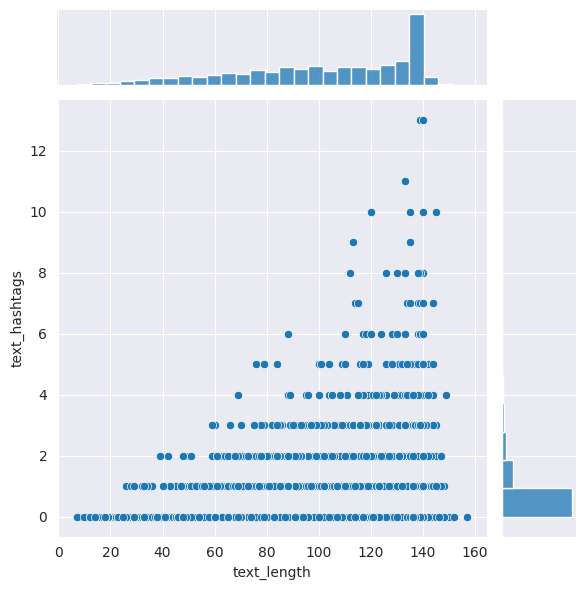

In [10]:
#plot frequency of hashtags against length of texts
ax = sns.jointplot(x=df['text_length'],y=df['text_hashtags']);

In [11]:
print(df['text_length'].corr(df['text_hashtags']))
print(df['text_length'].corr(df['target']))
print(df['target'].corr(df['text_hashtags']))

0.20820017459132784
0.18099679429364185
0.05951754415592287


target
0    4305
1    3198
Name: count, dtype: int64


<function matplotlib.pyplot.show(close=None, block=None)>

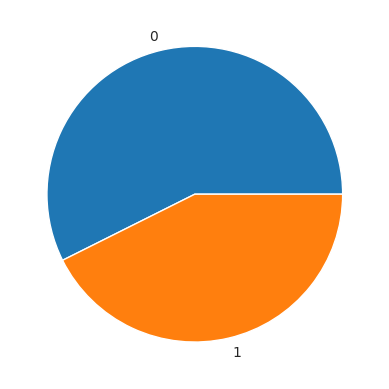

In [12]:
#plot target
print(target_count)
plt.pie(target_count, labels=[0,1]);
plt.show

From our exploratory data analysis, we find that there are 7,613 rows and 5 columns in our dataset. Each row represents a tweet and the text column stores the string. From this column, we can extract the length of each tweet (number of characters) and number of hashtags in each tweet. The length of tweets range from 7 to 157, and the frequency can see be seen on the histogram plot where the red line represents the average of 101 characters. In the box plot it can be seen there is a slightly higher median of 107, and a slight skew with a tail to the left. From the joint plot and correlation values calculated, it can be seen there is little correlation between the tweet length, number of hashtags used, and whether or not it is labeled as a disaster. There is also a relatively even split between the target counts with 4305 vs 3198 for 0 and 1 respectively.

**Part II: Data Preprocessing**

*a. Dealing with Missing Variables*

Based on the data info summary, there is no missing text from any of the rows (7316 non-null). Thus, although there are missing values in other columns, we only need the text column and do not need to deal with any missing variables.

*b. Other Preprocessing*

We want to preprocess our text to keep non-word characters (including hashtags,exclamations) for one of our tokenizers so that we can test with and without

In [13]:
def preprocessing(text):
    text = text.lower()
    return text

df['text_processed'] = df['text'].apply(preprocessing)
print(df['text_processed'].head(5))
    


0    our deeds are the reason of this #earthquake m...
1               forest fire near la ronge sask. canada
2    all residents asked to 'shelter in place' are ...
3    13,000 people receive #wildfires evacuation or...
4    just got sent this photo from ruby #alaska as ...
Name: text_processed, dtype: object


*c. Tokenization*

We will test with two tokenizers, one that splits the processed text by whitespace, and another which lemmatizes the words and removes the non-word characters

In [14]:
'''
import re
import spacy

nlp = spacy.load('en_core_web_sm')
lemmatizer = nlp.get_pipe('lemmatizer')

def tokenizer(tweet):
    #tokenizer 1
    doc = nlp(tweet)
    tokens = [token.text for token in doc]
    return tokens
    
def lemma_tokenizer(tweet):
    
    try:
        #tokenizer 2
        doc = nlp(tweet)
        tokens = []

        for token in doc:
            t = token.lemma_
            new_token = re.subn(r'\W','',t,count=len(t))
            if new_token[0] == '':
                continue
            tokens.append(new_token[0])

        return tokens
    except Exception as e:
        print(f"Exception in lemma_tokenizer: {e}")
        return None
'''

'\nimport re\nimport spacy\n\nnlp = spacy.load(\'en_core_web_sm\')\nlemmatizer = nlp.get_pipe(\'lemmatizer\')\n\ndef tokenizer(tweet):\n    #tokenizer 1\n    doc = nlp(tweet)\n    tokens = [token.text for token in doc]\n    return tokens\n    \ndef lemma_tokenizer(tweet):\n    \n    try:\n        #tokenizer 2\n        doc = nlp(tweet)\n        tokens = []\n\n        for token in doc:\n            t = token.lemma_\n            new_token = re.subn(r\'\\W\',\'\',t,count=len(t))\n            if new_token[0] == \'\':\n                continue\n            tokens.append(new_token[0])\n\n        return tokens\n    except Exception as e:\n        print(f"Exception in lemma_tokenizer: {e}")\n        return None\n'

In [15]:
'''
df['tokenized'] = df['text_processed'].apply(tokenizer)
df['tokenized_lemma'] = df['text_processed'].apply(lemma_tokenizer)
display(df.head(5))
'''

"\ndf['tokenized'] = df['text_processed'].apply(tokenizer)\ndf['tokenized_lemma'] = df['text_processed'].apply(lemma_tokenizer)\ndisplay(df.head(5))\n"

**Part III. Model Selection**

Since we are given the training set, we do not need to utilize train_test_split. We will fit the processed text and target values using GridSearchCV to find the best parameters for our GradientBoostingClassifier. It will test between unigrams and bigrams as well as our two different tokenizers. We also will try multiple max depths for the classifer.

In [16]:
#given training set, so no need to train_test_split
X_train = df.text_processed.values
y_train = df.target.values

print(X_train[0:5])

['our deeds are the reason of this #earthquake may allah forgive us all'
 'forest fire near la ronge sask. canada'
 "all residents asked to 'shelter in place' are being notified by officers. no other evacuation or shelter in place orders are expected"
 '13,000 people receive #wildfires evacuation orders in california '
 'just got sent this photo from ruby #alaska as smoke from #wildfires pours into a school ']


In [17]:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score

dummy_c = DummyClassifier(strategy='most_frequent').fit(X_train,y_train)
f1 = cross_val_score(dummy_c, X_train, y_train, cv=5, scoring='f1')

print(f"mean: {f1.mean().round(2)}, std:{f1.std().round(2)}")

mean: 0.0, std:0.0


In [18]:
import warnings
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

warnings.filterwarnings("ignore")

#given training set, so no need to train_test_split
X_train = df['text_processed'].values
y_train = df['target'].values

#create pipeline and parameters
pipe_dt = Pipeline([('vect', TfidfVectorizer()),
                     ('dt', DecisionTreeClassifier())
])

param_grid = {
    'vect__max_df': [0.5, 0.75, 1.0],
    'vect__max_features': [None, 2500, 5000, 7500],
    'vect__ngram_range': [(1, 1), (1, 2)],
    'dt__max_depth': [5,10,15]
}


gs_pipe_dt = GridSearchCV(estimator=pipe_dt,param_grid=param_grid,cv=2,n_jobs=-1,scoring='f1')
gs_pipe_dt.fit(X_train,y_train)


print(f'best parameters  : {gs_pipe_dt.best_params_}')
print(f'best cv accuracy : {gs_pipe_dt.best_score_.round(2):0.2f}')

best parameters  : {'dt__max_depth': 5, 'vect__max_df': 0.5, 'vect__max_features': 5000, 'vect__ngram_range': (1, 1)}
best cv accuracy : 0.58


With the best parameters and better accuracy, we can evaluate our test set.

**Part IV: Model Evaluation**

In [19]:
# Applying the same transformations to the test dataset:
dft = pd.read_csv("/kaggle/input/natural-language-processing-with-disaster-tweets/test.csv")

dft['text'] = dft['text'].apply(preprocessing)
X_test = dft['text']

est = gs_pipe_dt.best_estimator_
predictions = est.predict(X_test)

In [20]:
final_df = pd.DataFrame({
    'id': dft['id'],
    'target': predictions
})

final_df.to_csv('submission.csv',index=False)

In [21]:
final_df.head(5)

,id,target
0,0,0
1,2,0
2,3,1
3,9,0
4,11,0


In [22]:
!kaggle competitions submit -c nlp-getting-started -f submission.csv -m "Message"

Traceback (most recent call last):
  File "/opt/conda/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/opt/conda/lib/python3.10/site-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/opt/conda/lib/python3.10/site-packages/kaggle/api/kaggle_api_extended.py", line 403, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.
